# Sentiment Analysis

Using the previous web scraping methods and the current milestone, we have built this block of code that can retrieve, score, and plot sentiments accordingly.

This code snippet fetches product reviews from a Snapdeal product page. It uses the requests library to make an HTTP GET request to the URL, then parses the HTML content of the page with BeautifulSoup. The find_all method identifies all div elements with the class user-review, where the reviews are likely stored. The text content of these reviews is extracted, stripped of extra whitespace, and returned as a list.

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

def scrape_snapdeal_reviews():
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.81 Safari/537.36'
    }
    #Trial with different URLs
    url ='https://www.snapdeal.com/product/plastic-quick-cutter-vegetable-cutter/633340889475/reviews?page=13&sortBy=HELPFUL#defRevPDP'
    #url ='https://www.snapdeal.com/product/plastic-quick-cutter-vegetable-cutter/633340889475/reviews?page=12&sortBy=HELPFUL#defRevPDP'
    #url = 'https://www.snapdeal.com/product/plastic-quick-cutter-vegetable-cutter/633340889475/reviews?page=2&sortBy=HELPFUL#defRevPDP'
    response = requests.get(url, headers=headers)

    if response.status_code != 200:
        print(f"Failed to retrieve the webpage: {response.status_code}")
        return

    soup = BeautifulSoup(response.text, 'html.parser')

    # Extract reviews
    reviews = soup.find_all('div', class_='user-review')
    if not reviews:
        print("No reviews found. The site may be loading reviews dynamically with JavaScript.")
        return

    review_data = []

    for review in reviews:
        # Extract rating
        rating = review.find_all('i', class_='sd-icon sd-icon-star active')
        review_rating = len(rating)

        # Extract review title
        title_tag = review.find('div', class_='head')

        review_title = title_tag.text.strip() if title_tag else 'No Title'

        # Extract user name and date
        user_date_tag = review.find('div', class_='_reviewUserName')
        if user_date_tag:
            user_date_text = user_date_tag.text.strip()
            user_name, review_date = user_date_text.split(' on ') if ' on ' in user_date_text else (user_date_text, 'No Date')
        else:
            user_name = 'Anonymous'
            review_date = 'No Date'

        # Extract review text
        text_tag = review.find('p')
        review_text = text_tag.text.strip() if text_tag else 'No Review Text'
        if review_date=="No Date":
          pass
        else:
          review_data.append({
              'Rating': review_rating,
              'Review Title': review_title,
              'User Name': user_name,
              'Date': review_date,
              'Review Text': review_text
          })

    # Save to CSV
    df = pd.DataFrame(review_data)
    df.to_csv('snapdeal_product_reviews.csv', index=False)
    print("Scraping completed and data saved to 'snapdeal_product_reviews.csv'.")

# Execute the scraping function
scrape_snapdeal_reviews()

Scraping completed and data saved to 'snapdeal_product_reviews.csv'.


**Importing Necessary Header files <br>**
**Also calling the sentiment analysis model<br>**
This snippet imports necessary libraries for data handling, visualization, and sentiment analysis. It initializes a sentiment analysis pipeline using a pre-trained DistilBERT model, optimized for positive and negative sentiment classification.

In [ ]:
import pandas as pd
from transformers import pipeline
import matplotlib.pyplot as plt

sentiment_analyzer = pipeline(
    "sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english", device=0
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


**Function to convert the date into 'Date Time ' Datatype<br>**
This function reads a CSV file containing review data and converts the "Date" column into a datetime format for easier processing. It ensures that dates are in a usable format for analysis. Finally, it returns the processed data.

In [ ]:
def preprocess_review_data(file_path):
    data = pd.read_csv(file_path)
    data["Date"] = pd.to_datetime(data["Date"])
    return data

**Function which analyses the sentiment<br>**
This function determines the sentiment of a given text using the sentiment analysis model. It analyzes the text and returns the sentiment label, such as "POSITIVE" or "NEGATIVE." If an error occurs during analysis, it logs the error message and assigns a default sentiment of "NEUTRAL." This ensures robust handling of any issues.

In [ ]:
def get_sentiment(text):
    try:
        result = sentiment_analyzer(text)
        print(f"Sentiment result for '{text}': {result}")
        sentiment = result[0]["label"]
        return sentiment
    except Exception as e:
        print(f"Error analyzing sentiment for text: {text}, Error: {e}")
        return "NEUTRAL"

**This function rates the sentiment score and decides whether it is positive , negative or Neutral<br>**
This function prepares the dataset for sentiment trend analysis. It converts the Date column into a datetime format for easier grouping. The Sentiment_Label column is mapped to numerical values (1 for positive, -1 for negative), enabling computation. Sentiment scores are averaged for each date using groupby and returned as a DataFrame.

In [ ]:
def aggregate_sentiment(sentiment_df):
    # Create separate columns for positive and negative sentiment counts
    sentiment_df["positive"] = sentiment_df["sentiment"].apply(lambda x: 1 if x == "POSITIVE" else 0)
    sentiment_df["negative"] = sentiment_df["sentiment"].apply(lambda x: 1 if x == "NEGATIVE" else 0)

    # Group by Date and calculate the total counts for positive and negative
    sentiment_agg = sentiment_df.groupby("Date")[["positive", "negative"]].sum().reset_index()
    return sentiment_agg

**This function plots the sentiment into a Histogram<br>**
This function creates a histogram to visualize the distribution of sentiments in the provided DataFrame. It counts the occurrences of each sentiment label (positive or negative), then plots a bar chart where positive sentiments are shown in green and negative ones in red. The chart includes labels for clarity and is displayed using plt.show().

In [ ]:
def plot_sentiment_histogram(sentiment_df):
    sentiment_counts = sentiment_df["sentiment"].value_counts()
    sentiments = sentiment_counts.index.tolist()
    counts = sentiment_counts.values.tolist()
    plt.bar(sentiments, counts, color=["green", "red"])  # Positive (green) and Negative (red)
    plt.title("Sentiment Histogram")
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.show()

**This function plots a regression analysis of the Data obtained<br>**
This snippet fits a linear regression model to the sentiment trend data, providing a trend line. The independent variable x represents the index of the dates, while the dependent variable y contains the sentiment scores. The model's predictions are plotted as a red line alongside the scatter plot of actual sentiment scores for visual comparison.

In [ ]:
from sklearn.linear_model import LinearRegression

def plot_sentiment_with_regression(sentiment_agg):
    sentiment_agg["ordinal_date"] = sentiment_agg["Date"].apply(lambda x: x.toordinal())
    X = sentiment_agg["ordinal_date"].values.reshape(-1, 1)
    y = sentiment_agg["positive"].values
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    plt.scatter(sentiment_agg["Date"], sentiment_agg["positive"], color="green", label="Positive Sentiment")
    plt.scatter(sentiment_agg["Date"], sentiment_agg["negative"], color="red", label="Negative Sentiment")
    plt.plot(sentiment_agg["Date"], y_pred, color="blue", label="Regression Line (Positive)")
    plt.title("Sentiment Analysis with Regression Line")
    plt.xlabel("Date")
    plt.ylabel("Sentiment Count")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

**The main Function<br>**
This main function orchestrates the entire sentiment analysis process. It first preprocesses the review data, then applies sentiment analysis to each review's text. Next, it aggregates the sentiment data by date and prints the results. It also generates a sentiment histogram and performs a regression analysis to show sentiment trends over time.

In [ ]:
def main(file_path):
    review_data = preprocess_review_data(file_path)
    review_data["sentiment"] = review_data["Review Text"].apply(get_sentiment)
    sentiment_agg = aggregate_sentiment(review_data)

    print("Aggregated Sentiment DataFrame:")
    print(sentiment_agg)
    print("Histogram : ")
    plot_sentiment_histogram(review_data)

    print("Analysis of the reviews : ")
    plot_sentiment_with_regression(sentiment_agg)

Sentiment result for 'Product is fine. But not as per the picture in the site. But no harm done. Quality is ok.': [{'label': 'POSITIVE', 'score': 0.9996289014816284}]
Sentiment result for 'Quality is bad. Once  drop is enough to break into pieces': [{'label': 'NEGATIVE', 'score': 0.9997909665107727}]
Sentiment result for 'It makes lot of unexpected voice while chopping it feels it's going to break soon': [{'label': 'NEGATIVE', 'score': 0.9480164647102356}]
Sentiment result for 'Lid is not fitting properly other wise ok': [{'label': 'NEGATIVE', 'score': 0.9996139407157898}]
Sentiment result for 'I would like to return this "HOMETALES COMPACT MA.. FDUXCHOPE as it's of poor quality': [{'label': 'NEGATIVE', 'score': 0.9994812607765198}]
Sentiment result for 'Nothing more than toy.': [{'label': 'NEGATIVE', 'score': 0.9966464638710022}]
Sentiment result for 'This quick cutter is very useful. Nice product.': [{'label': 'POSITIVE', 'score': 0.9996765851974487}]
Sentiment result for 'The blade 

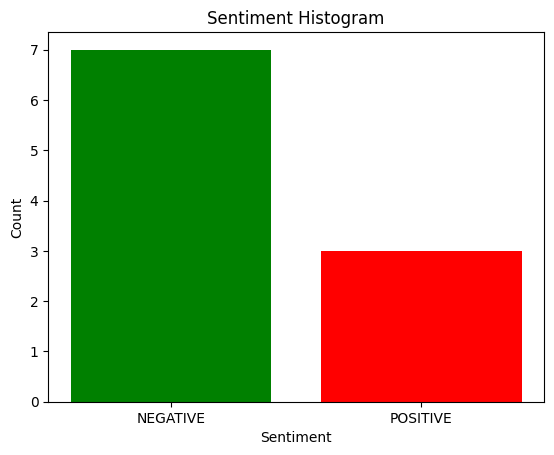

Analysis of the reviews : 


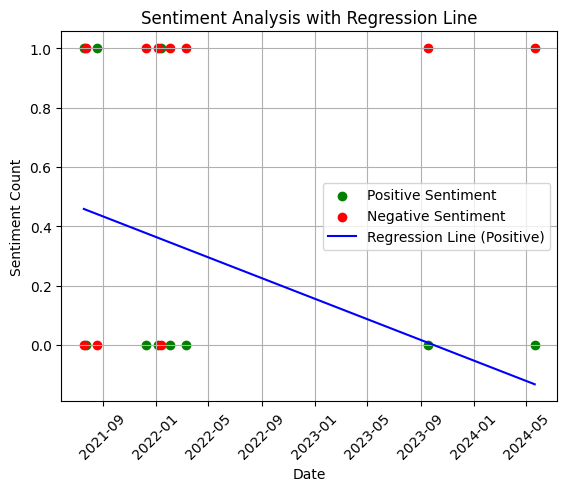

In [ ]:
if __name__ == "__main__":
    file_path = "snapdeal_product_reviews.csv"
    main(file_path)

**Inferences : <br>**
The code generates a sentiment analysis of product reviews, producing three key outputs:

Sentiment Histogram: A bar chart displaying the distribution of positive (green) and negative (red) sentiments, showing the overall sentiment of the reviews.

Aggregated Sentiment Data: A table summarizing the counts of positive and negative sentiments grouped by date, revealing trends over time.

Sentiment with Regression Line: A scatter plot with a regression line to visualize sentiment trends, helping identify whether sentiment has improved or declined over time.

These outputs offer insights into the overall reception of the product and sentiment trends over time.